In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import datetime
from IPython import display

In [ ]:
OUTPUT_CHANNELS = 3

test_y_path='drive/My Drive/test_dir/DIV2K_valid_LR_bicubic_X4/DIV2K_valid_LR_bicubic/X4/0805x4.png'
test_x_path='drive/My Drive/test_dir/DIV2K_valid_LR_unknown_X4/DIV2K_valid_LR_unknown/X4/0805x4.png'

BATCH_SIZE = 1

In [ ]:
def show_image(image,title):
    plt.title(title)
    plt.imshow(image)
    plt.show()

In [ ]:
def random_patch(image, size):
    
    h,w,_ = image.shape
    
    rand_h = np.random.randint(h - size[0])
    rand_w = np.random.randint(w - size[1])
    
    return rand_h , rand_w 

In [ ]:
def crop_random(image, size, rand_h=-1, rand_w=-1):

  if rand_h==-1 or rand_w==-1 :

    rand_h , rand_w = random_patch(image, size)
 
  return image[rand_h:(rand_h + size[0]), rand_w:(rand_w + size[1]), :]

In [ ]:
def div2k_path_list(path,st=0,en=801,sc='',f='.png'):

    count=[c for c in range(st,en)]
    
    remv=[21,22,122,139,145,205,243,340,352,387,437,518,523,627,710,455,527,560,581,685]

    for elm in remv :
      if elm in count:
        count.remove(elm)

    paths=[os.path.join(path,(4-len(str(x)))*'0'+str(x)+sc+f) for x in count]

    return paths

In [ ]:
def load(image_file):
    
    image=tf.io.read_file(image_file)
    image=tf.io.decode_png(image)
    image=tf.cast(image, tf.float32)
    
    return image

In [ ]:
@tf.function
def unet_patch(image,size,scale):
    
    dh=size[0]*scale
    dw=size[1]*scale
    
    img1=image[:dh ,:dw ,:]
    img2=image[:dh ,-dw:,:]    
    img3=image[-dh:,:dw ,:]    
    img4=image[-dh:,-dw:,:]

    return tf.convert_to_tensor([img1,img2,img3,img4])

In [ ]:
@tf.function
def data_augment(images):
    
    HF=images[:, :, ::-1, :]
    
    # VF=images[:, ::-1, :, :]

    # return tf.concat([images,HF,VF],axis=0)
    return HF

In [ ]:
def normalize(image):
    
    image = (image / 127.5) - 1
    return image

In [ ]:
def denormalize(image):
    
    return (image + 1) * 127.5

In [ ]:
def preprocess_image(path,size=(256,256),scale=1):
    
    image=load(path)
    
    patches=unet_patch(image,size,scale)
    
    patches=data_augment(patches)
    
    images=normalize(patches)
    
    return images

In [ ]:
def shuffle(paths_c,paths_n):

  idx=np.random.permutation(len(paths_c)) 

  paths_c=np.array(paths_c)[idx]

  idx=np.random.permutation(len(paths_n)) 

  paths_n=np.array(paths_n)[idx]

  return paths_c,paths_n

In [ ]:
clean_path='drive/My Drive/DIV2K/DIV2K_train_LR_bicubic_X4/DIV2K_train_LR_bicubic/X4/'

noisy_path='drive/My Drive/DIV2K/DIV2K_train_LR_unknown_X4/DIV2K_train_LR_unknown/X4/'

paths_c=div2k_path_list(clean_path,st=401,en=801,sc='x4',f='.png')

paths_n=div2k_path_list(noisy_path,st=1,en=401,sc='x4',f='.png')

paths_c,paths_n =shuffle(paths_c,paths_n)

# split_c = np.split(paths_c, 13)

# split_n = np.split(paths_n, 13)

In [ ]:
def training_dataset(paths):
  
  train_dataset = tf.data.Dataset.from_tensor_slices(paths)

  train_dataset = train_dataset.cache().map(preprocess_image,
                                    num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # train_x = train_x.batch(BATCH_SIZE)
  return train_dataset

In [ ]:
def create_dataset(paths_n,paths_c):

  train_x=training_dataset(paths_n)

  train_y=training_dataset(paths_c)

  return train_x , train_y

In [ ]:
def test(path_x,path_y,generator,size=(256,256)):

    test_x=load(path_x)

    test_y=load(path_y)
    
    h , w = random_patch(test_x, size)

    x=crop_random(test_x, size, h , w)
    
    y=crop_random(test_y, size, h , w)

    g=(np.expand_dims(normalize(x), axis=0))
    y_hat=generator.predict(g)

    plt.figure(figsize=(8,6))
    show_image(keras.preprocessing.image.array_to_img(x),'source domain')

    plt.figure(figsize=(8,6))
    show_image(keras.preprocessing.image.array_to_img(y_hat[0]),'predicted')

    print('PSNR : ',tf.image.psnr(y, denormalize(y_hat[0]),max_val=255).numpy())
    print('SSIM : ',tf.image.ssim(y, denormalize(y_hat[0]),max_val=255).numpy())

    plt.figure(figsize=(8,6))
    show_image(keras.preprocessing.image.array_to_img(y),'target domain')


In [ ]:
def dense_block(inp,num_filter,residual_scaling):
    
    x1 = keras.layers.Conv2D(num_filter, kernel_size=3, strides=1, padding='same',
                             kernel_initializer='lecun_normal', activation='selu')(inp)
    x1 = keras.layers.Concatenate()([inp, x1])

    x2 = keras.layers.Conv2D(num_filter*2, kernel_size=3, strides=1, padding='same',
                             kernel_initializer='lecun_normal')(x1)
    x2 = keras.layers.Concatenate()([inp, x1, x2])

    x3 = keras.layers.Conv2D(inp.shape[3], kernel_size=3, strides=1, padding='same',
                             kernel_initializer='lecun_normal', activation='selu')(x2)

    x3 = keras.layers.Lambda(lambda t: t * residual_scaling)(x3)

    out = keras.layers.Add()([x3, inp])

    return out

In [ ]:
def RDRDB(inp,residual_scaling,num_filter):
    '''Residual Dense in Residual Dense Block'''
    
    x1 = dense_block(inp,num_filter,residual_scaling)
#     x1 = keras.layers.Concatenate()([inp, x1])
    
#     x2 = dense_block(x1,num_filter,residual_scaling)
#     x2 = keras.layers.Concatenate()([inp, x1 , x2])

#     x3 = dense_block(x2,num_filter/2,residual_scaling) # num_filter == inp.shape[3] ---64,128,256

#     x3 = keras.layers.Lambda(lambda t: t *residual_scaling)(x3)
#     print(x3.shape, inp.shape)

#     out = keras.layers.Add()([x3, inp])
    
    return x1

In [ ]:
def downsample(inp,residual_scaling,num_filter):
    
    x = RDRDB(inp,residual_scaling,num_filter)
#     x = RDRDB(x,residual_scaling,num_filter)
#     x = RDRDB(x,residual_scaling,num_filter)
    
    result = keras.layers.Conv2D(num_filter, 3, strides=2, padding='same',
                             kernel_initializer='lecun_normal', use_bias=False)(x)

#     if apply_batchnorm:
#         result.add(keras.layers.BatchNormalization())

    return result

In [ ]:
def upsample(inp,residual_scaling,num_filter):
    
    x = RDRDB(inp,residual_scaling,num_filter)
#     x = RDRDB(x,residual_scaling,num_filter)
#     x = RDRDB(x,residual_scaling,num_filter)
    
    result = keras.layers.Conv2DTranspose(num_filter, 3, strides=2, padding='same',
                             kernel_initializer='lecun_normal', use_bias=False)(x)

#     result.add(tf.keras.layers.BatchNormalization())

#     if apply_dropout:
#         result.add(tf.keras.layers.Dropout(0.5))

    return result

In [ ]:
def build_Generator(name,residual_scaling=0.2):
    
    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    
#     temp=keras.layers.Conv2D(64, 3, strides=1, padding='same',
#                              kernel_initializer='lecun_normal', use_bias=False)(inputs)
    
    x1=downsample(inputs,residual_scaling,32 )  # (batch_size, 128, 128, 64)
        
    x2=downsample(x1,residual_scaling,64)  # (batch_size, 64, 64, 128)
        
    x3=downsample(x2,residual_scaling,128)  # (batch_size, 32, 32, 256)
    
    x4=upsample(x3,residual_scaling,128)  # (batch_size, 32, 32, 512)
    x4=keras.layers.Concatenate()([x4, x2])

    x5=upsample(x4,residual_scaling,64)  # (batch_size, 64, 64, 256)
    x5=keras.layers.Concatenate()([x5, x1])

#     x6=upsample(x5,residual_scaling,32)  # (batch_size, 128, 128, 128)


#     initializer = tf.random_normal_initializer(0., 0.02)
    x = keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer='lecun_normal',
                                         activation='tanh')(x5)  # (batch_size, 256, 256, 3)

    return keras.models.Model(inputs=inputs, outputs=x,name=name)

In [ ]:
generator_1=build_Generator('G1') #X-->Y
generator_2=build_Generator('G2') #Y--X

# generator_1.summary()

In [ ]:
# tf.keras.utils.plot_model(generator_1, show_shapes=True, dpi=64)

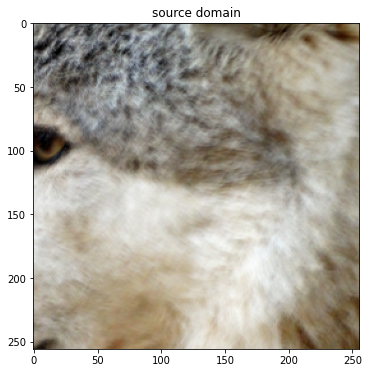

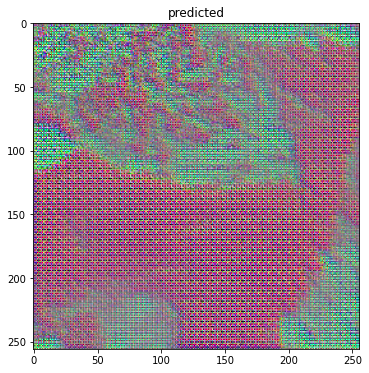

PSNR :  8.981594
SSIM :  0.017016297


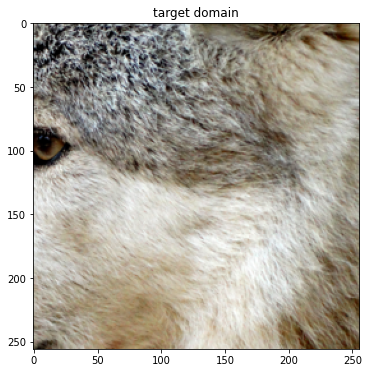

In [ ]:
test(test_x_path,test_y_path,generator_1)

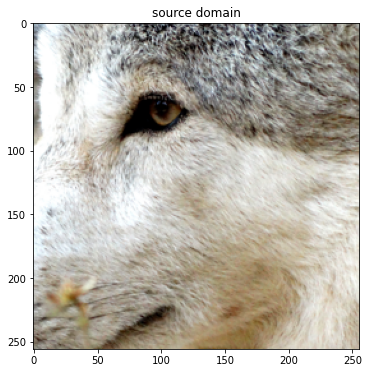

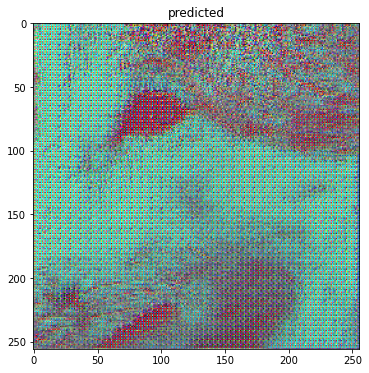

PSNR :  9.5459175
SSIM :  0.03761887


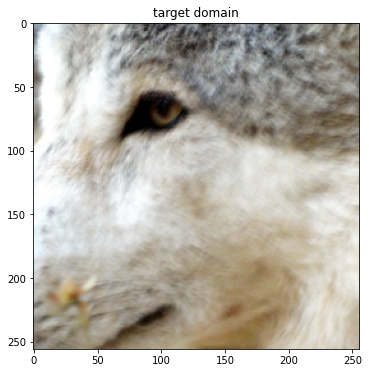

In [ ]:
test(test_y_path,test_x_path,generator_2)

In [ ]:
def build_Discriminator(name,residual_scaling=0.2):
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')

    x1=downsample(inp,residual_scaling,32 )  # (batch_size, 128, 128, 64)
    
    x2=downsample(x1,residual_scaling,64)  # (batch_size, 64, 64, 128)
        
    x3=downsample(x2,residual_scaling,128)  # (batch_size, 32, 32, 256)
    

    x4 = keras.layers.Conv2D(256, 3, strides=1,padding='same',
                                kernel_initializer='lecun_normal', activation='selu',
                                use_bias=False)(x3)  # (batch_size, 32, 32, 512)

    x = keras.layers.Conv2D(1, 3, strides=1,padding='same',
                                kernel_initializer='lecun_normal')(x4)  # (batch_size, 32, 32, 1)

    return keras.models.Model(inputs=inp, outputs=x , name=name)

In [ ]:
discriminator_1 = build_Discriminator('D1')
discriminator_2 = build_Discriminator('D2')
# discriminator_1.summary()

In [ ]:
# tf.keras.utils.plot_model(discriminator_1, show_shapes=True, dpi=64)

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

In [ ]:
def base_loss(y_predict, y_true,alpha=0.1):

    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(y_predict - y_true))
    
    fft_loss=tf.reduce_mean(tf.square(
        tf.signal.fft(tf.cast(y_predict,tf.complex64))-
        tf.signal.fft(tf.cast(y_true,tf.complex64))
    ))
    
    pixel_loss=alpha*(tf.cast(fft_loss,tf.float32))+((1-alpha)*l1_loss)

    content_loss=calc_content_loss(y_predict,y_true,densenet)

    edge_loss=calc_edge_loss( y_predict,y_true)

    total_loss = pixel_loss + edge_loss + content_loss

    return  total_loss

In [ ]:
def generator_loss(generated):
  return loss_object(tf.ones_like(generated), generated)

In [ ]:
# def calc_tv_loss( y_true,y_pred):

#     tv_loss = tf.reduce_sum(tf.image.total_variation(y_pred))
#     # tv_loss = tf.reduce_mean(tf.square(tf.image.total_variation(y_pred)-tf.image.total_variation(y_true)))

#     return tv_loss*0.0001

In [ ]:
def calc_edge_loss( y_true,y_pred):

    sobel_loss = tf.sqrt(tf.reduce_sum(tf.square(tf.image.sobel_edges(y_pred)-tf.image.sobel_edges(y_true))))
    # tv_loss = (-1)*tf.sqrt(tf.reduce_sum(tf.square(tf.image.sobel_edges(y_pred))))
    return sobel_loss*0.0001

In [ ]:
def calc_content_loss(y_pred,y_true,prenet):

  # content_loss=base_loss(prenet(y_pred), prenet(y_true))
  content_loss=tf.reduce_mean(tf.square(prenet(y_pred)-prenet(y_true)))

  return content_loss*0.001

In [ ]:
def identity_loss(real_image, same_image):
  # loss = tf.reduce_mean(tf.abs(real_image - same_image))
  loss=base_loss(real_image, same_image)
  return LAMBDA * 0.5 * loss

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  # loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  loss1=base_loss(real_image, cycled_image)
  return LAMBDA * loss1

In [ ]:
densenet = tf.keras.applications.DenseNet121(weights="imagenet",include_top=False,input_shape= (None,None,3))
# densenet.get_layer('bn').activation=None# before activation
outputs = densenet.get_layer('bn').output
densenet=keras.models.Model(densenet.input, outputs,name='densenet')
densenet.trainable = False
# densenet.summary()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    
    real_loss = loss_object(tf.ones_like(disc_real_output)*0.9, disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss* 0.5

In [ ]:
generator_1_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_2_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_2_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_1_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
generator_1.load_weights('drive/My Drive/thesis_result/models/G1_weights.h5')
generator_2.load_weights('drive/My Drive/thesis_result/models/G2_weights.h5')
discriminator_1.load_weights('drive/My Drive/thesis_result/models/D1_weights.h5')
discriminator_2.load_weights('drive/My Drive/thesis_result/models/D2_weights.h5')

In [ ]:
test(test_x_path,test_y_path,generator_1)

In [ ]:
test(test_y_path,test_x_path,generator_2)

In [ ]:
a3# for interrupt and error

In [ ]:
checkpoint_dir = 'drive/My Drive/training_checkpoints/part1/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_1=generator_1,
                           generator_2=generator_2,
                           discriminator_1=discriminator_1,
                           discriminator_2=discriminator_2,
                           generator_1_optimizer=generator_1_optimizer,
                           generator_2_optimizer=generator_2_optimizer,
                           discriminator_1_optimizer=discriminator_1_optimizer,
                           discriminator_2_optimizer=discriminator_2_optimizer)
ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#     checkpoint.restore(ckpt_manager.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(real_x, real_y, step):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator 1 translates X -> Y
    # Generator 2 translates Y -> X.
    
    fake_y = generator_1(real_x, training=True)
    cycled_x = generator_2(fake_y, training=True)

    fake_x = generator_2(real_y, training=True)
    cycled_y = generator_1(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_2(real_x, training=True)
    same_y = generator_1(real_y, training=True)

    disc_real_x = discriminator_2(real_x, training=True)
    disc_real_y = discriminator_1(real_y, training=True)

    disc_fake_x = discriminator_2(fake_x, training=True)
    disc_fake_y = discriminator_1(fake_y, training=True)

    # calculate the loss
    gen_1_loss = generator_loss(disc_fake_y)
    gen_2_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_1_loss = gen_1_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_2_loss = gen_2_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_2_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_1_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_1_gradients = tape.gradient(total_gen_1_loss, 
                                        generator_1.trainable_variables)
  generator_2_gradients = tape.gradient(total_gen_2_loss, 
                                        generator_2.trainable_variables)
  
  discriminator_2_gradients = tape.gradient(disc_2_loss, 
                                            discriminator_2.trainable_variables)
  discriminator_1_gradients = tape.gradient(disc_1_loss, 
                                            discriminator_1.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_1_optimizer.apply_gradients(zip(generator_1_gradients, 
                                            generator_1.trainable_variables))

  generator_2_optimizer.apply_gradients(zip(generator_2_gradients, 
                                            generator_2.trainable_variables))
  
  discriminator_2_optimizer.apply_gradients(zip(discriminator_2_gradients,
                                                discriminator_2.trainable_variables))
  
  discriminator_1_optimizer.apply_gradients(zip(discriminator_1_gradients,
                                                discriminator_1.trainable_variables))
  
  with summary_writer.as_default():
        tf.summary.scalar('G1', total_gen_1_loss, step=step)#1000
        tf.summary.scalar('D1', disc_1_loss, step=step)
        tf.summary.scalar('G2', total_gen_2_loss, step=step)
        tf.summary.scalar('D2', disc_2_loss, step=step)

In [ ]:
# def fit(train_x , train_y, steps):
# def fit(split_n , split_c, steps):
def fit(paths_n , paths_c, steps):

#     example_input, example_target = next(iter(test_ds.take(1)))
    start = datetime.datetime.now()
    # e=[]
    # train_x , train_y=create_dataset(paths_n[np.random.randint(0,len(paths_n),39)],paths_c[np.random.randint(0,len(paths_c),39)])

    for step in range(steps):
        
        # tic = datetime.datetime.now()

        # for path_n_10, path_c_10 in zip(split_n,split_c):

        # train_x , train_y=create_dataset(split_n[step],split_c[step])
        train_x , train_y=create_dataset(paths_n[index],paths_c[index])
        # train_x , train_y=create_dataset(paths_n[np.random.randint(0,len(paths_n),39)],paths_c[np.random.randint(0,len(paths_c),39)])


        for input_image, target in tf.data.Dataset.zip((train_x, train_y)):
          # for i in range(0,12,2):
            # shuf=np.random.permutation(len(input_image)) 

            # input_image=np.array(input_image)[shuf]

            # target=np.array(target)[shuf]
            for image_x , image_y in zip(input_image, target):
            


#     for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
#         if (step) % 1000 == 0:
#             display.clear_output(wait=True)

#             if step != 0:
#                 print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

#             start = time.time()

#             generate_images(generator, example_input, example_target)
#             print(f"Step: {step//1000}k")
                # tic = datetime.datetime.now()

                train_step(tf.reshape(image_x,(1,256,256,3)), tf.reshape(image_y,(1,256,256,3)), step)
                # train_step(input_image[i:i+2,:,:,:], target[i:i+2,:,:,:], step)

                # print ('Time taken for 1 image is {} sec\n'.format(datetime.datetime.now()-tic))  
            # print('.', end='', flush=True) 
                # break
            # break

        # print ('Time taken for epoch {} is {} sec\n'.format(step + 1,
        #                                                   datetime.datetime.now()-tic))
        # Training step
#         if (step+1) % 10 == 0:
        # print('.', end='', flush=True)


        # Save (checkpoint) the model every 5k steps
        # if (step + 1) % 5 == 0:#5000
        # checkpoint.save(file_prefix=checkpoint_prefix)

        # if step+1  == 10:
        # ckpt_save_path = ckpt_manager.save()
        # print ('Saving checkpoint for epoch {} at {}'.format(step+1,
        #                                                     ckpt_save_path))
            
    print('Time taken for All steps: {} sec\n'.format(datetime.datetime.now()-start))
    
#         if (epoch + 1) % 5 == 0:
#             ckpt_save_path = ckpt_manager.save()
#             print ('Saving checkpoint for epoch {} at {}'.format(step+1,
#                                                              ckpt_save_path))

In [ ]:
# train_x , train_y=create_dataset(paths_n,paths_c)

In [ ]:
# fit(train_x , train_y, steps=2)

In [ ]:
# fit(split_n,split_c, steps=1)

In [ ]:
index=[287, 65,  60 ,132 , 61,  95 , 27, 251, 278,  87, 139,  52 ,359 ,340 ,181,  15 ,102 ,118,
 300, 351,  92, 102, 285, 160, 329, 308,  94, 340 ,167, 329, 375,  99, 249, 184, 145,  2,
 169, 150, 131]

In [ ]:
fit(paths_n , paths_c, steps=10)

Saving checkpoint for epoch 1 at drive/My Drive/training_checkpoints/part1/ckpt-1
Saving checkpoint for epoch 2 at drive/My Drive/training_checkpoints/part1/ckpt-2
Saving checkpoint for epoch 3 at drive/My Drive/training_checkpoints/part1/ckpt-3
Saving checkpoint for epoch 4 at drive/My Drive/training_checkpoints/part1/ckpt-4
Saving checkpoint for epoch 5 at drive/My Drive/training_checkpoints/part1/ckpt-5
Saving checkpoint for epoch 6 at drive/My Drive/training_checkpoints/part1/ckpt-6
Saving checkpoint for epoch 7 at drive/My Drive/training_checkpoints/part1/ckpt-7
Saving checkpoint for epoch 8 at drive/My Drive/training_checkpoints/part1/ckpt-8
Saving checkpoint for epoch 9 at drive/My Drive/training_checkpoints/part1/ckpt-9
Saving checkpoint for epoch 10 at drive/My Drive/training_checkpoints/part1/ckpt-10
Time taken for All steps: 0:17:49.464150 sec



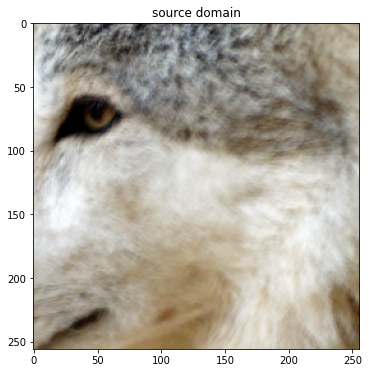

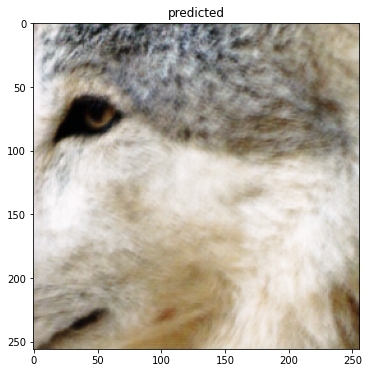

PSNR :  23.541592
SSIM :  0.529671


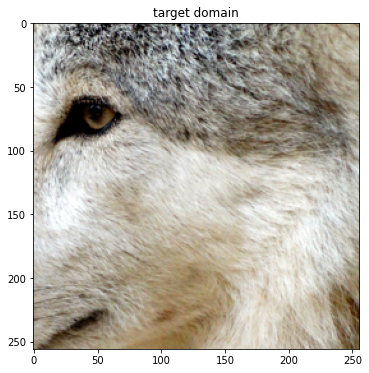

In [ ]:
test(test_x_path,test_y_path,generator_1)

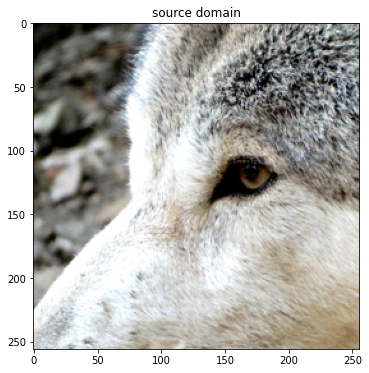

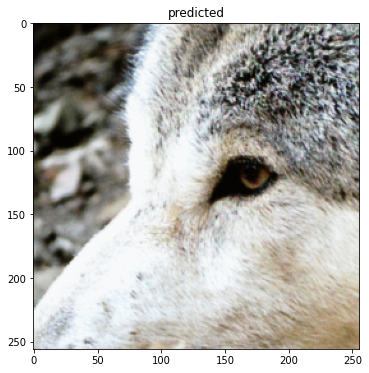

PSNR :  23.660421
SSIM :  0.6682515


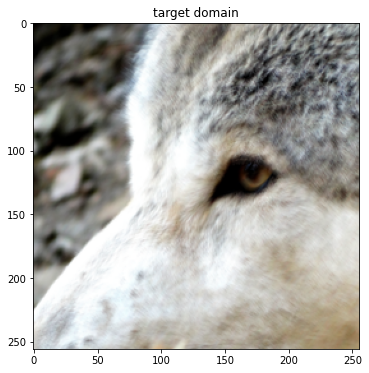

In [ ]:
test(test_y_path,test_x_path,generator_2)

In [ ]:
# test(test_x_path,test_y_path,generator_1,size=(28,28))

In [ ]:
# test(test_y_path,test_x_path,generator_2,size=(28,28))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 647), started 1:25:55 ago. (Use '!kill 647' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
generator_1.save('drive/My Drive/thesis_result/models/G1.h5')
generator_2.save('drive/My Drive/thesis_result/models/G2.h5')
discriminator_1.save('drive/My Drive/thesis_result/models/D1.h5')
discriminator_2.save('drive/My Drive/thesis_result/models/D2.h5')
generator_1.save_weights('drive/My Drive/thesis_result/models/G1_weights.h5')
generator_2.save_weights('drive/My Drive/thesis_result/models/G2_weights.h5')
discriminator_1.save_weights('drive/My Drive/thesis_result/models/D1_weights.h5')
discriminator_2.save_weights('drive/My Drive/thesis_result/models/D2_weights.h5')

In [ ]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#     width="100%",
#     height="1000px")

In [ ]:
# !ls {checkpoint_dir}
# Restoring the latest checkpoint in checkpoint_dir
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
# Run the trained model on a few examples from the test set
# for inp, tar in test_dataset.take(5):
#   generate_images(generator, inp, tar)

In [ ]:
# fit(train_x , train_y, steps=2)